### Case Study

The VIX is a measure of the implied volatility for the S&P500. The higher the "Close" of the VIX, the higher the uncertainty in the market. Fortunately, there are ways of capitlizing on the predictability of the VIX. Being able to predict implied volatility for the market with any degree of certainty better than 50/50 can give an options trader of ETF trader (VIX tracking ETF's) an edge.

There could be many, many features that impact whether a stock price goes up or down. Predicting directionality for stocks, the VIX, commodities, FX etc represents a huge potential gain for every small percentage increment in forecast ability.

However, having so many features allows room for noise and can create adverse impacts to your supervised learning. Therefore, we will explore deplying PCA (Principle Component Analysis) as a tool to find useful information within a vast array of indicators and features to help with our supervised learning later on.

PCA can equally be extremely good at helping to understand correlations too and further study on PCS (based on articles and papers below) is encorouged.

### Imports

In [1]:
# Remove unwanted warnings
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data Management
import pandas as pd
import numpy as np
from sklearn import tree

from ta import add_all_ta_features
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import sklearn.mixture as mix
# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import pickle

# Reporting
import matplotlib.pyplot as plt
import yfinance
from matplotlib.pylab import rcParams
from xgboost import plot_tree


In [2]:
def hurst(ts, min_lag=1, max_lag=100):
    lags = range(min_lag, max_lag)
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = polyfit(log(lags), log(tau), 1)
    return poly[0]*2.0

In [3]:
findFeature = True
#[OLECTRA,"LT","CONCOR","ELGIEQUIP","IOC","BEL","TATAELXSI","^NSEI"]
stock_name = "IOC.NS"
disableStationaryCheck = False
features = []
if findFeature == False:
    with open('./TrainedModel/indicator/{}_features.txt'.format(stock_name), 'rb') as f:
            features = pickle.load(f)
            print(feature_item)
            features.append("TARGET")



### Initial Data Extraction

In [4]:


# Data Extraction
start_date = "2017-01-01"
end_date = "2022-06-01"
#symbol = "IOC.NS"

#df = yfinance.download(tickers = stock_name,start="2010-03-06",
 #                              interval = "1d", group_by = 'ticker', auto_adjust = True)

df = pd.read_csv("./stock_historical_data/{}.csv".format(stock_name))
df.set_index("Date", inplace=True)

df = df[["Open", "High", "Low", "Close","Volume"]]
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2023-07-04,96.000000,96.400002,94.349998,94.650002,11918401
2023-07-05,95.150002,95.699997,93.400002,95.500000,14283796
2023-07-06,96.000000,98.800003,96.000000,98.599998,32778334
2023-07-07,99.449997,101.250000,98.800003,99.199997,37546405
2023-07-10,101.000000,101.449997,97.099998,97.400002,24037673


In [5]:
df_nifty = pd.read_csv("./stock_historical_data/{}.csv".format("^NSEI"))
df_nifty.set_index("Date", inplace=True)

df_nifty = df_nifty[["Open", "High", "Low", "Close","Volume"]]
df_nifty.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2023-07-04,19406.599609,19434.150391,19300.000000,19389.000000,226900
2023-07-05,19405.949219,19421.599609,19339.599609,19398.500000,224400
2023-07-06,19385.699219,19512.199219,19373.000000,19497.300781,268300
2023-07-07,19422.800781,19523.599609,19303.599609,19331.800781,237100
2023-07-10,19400.349609,19435.849609,19327.099609,19355.900391,0


In [6]:
df["NiftyReturn"] = df_nifty["Close"].pct_change()

In [66]:
#check last day positive return or not
new_df = []
new_df_1 = []

for i in range(0,len(df)):
    if i < 2:
        new_df.append(np.nan)
        new_df_1.append(np.nan)

    else:
        if df.iloc[i-1].Open < df.iloc[i-1].Close:
            new_df.append(1)
        else:
            new_df.append(0)
        if df.iloc[i-1].Open < df.iloc[i-1].Close and df.iloc[i-2].Open < df.iloc[i-2].Close:
            new_df_1.append(1)
        else:
            new_df_1.append(0)

            


    

In [67]:
print(len(new_df_1),"sdf: ",len(new_df))

3873 sdf:  3873


In [68]:
df["previous_day"] = new_df
df["previous_two_day"] = new_df_1

In [69]:
df = df.dropna()

In [70]:
# Add TA
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}volume_adi"] = AccDistIndexIndicator(
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}volume_obv"] = OnBalanceVolumeIndicator(
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:101: SettingWithCopyWarning: 
A value is trying to be set 

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}trend_cci"] = CCIIndicator(
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{colprefix}trend_visual_ichimoku_a"] = indicator_ichi_visual.ichimoku_a()
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/wrapper.py:368: SettingWithCopyWarning: 
A value is try

In [71]:
df  = df.dropna()

### Data Preprocessing - Stationarity

In [72]:
# Identify non-stationary columns

non_stationaries = []
for col in df.columns:
    dftest = adfuller(df[col].values)
    p_value = dftest[1]
    t_test = dftest[0] < dftest[4]["1%"]
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 30


In [73]:
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [74]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

In [75]:
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)

df_stationary.head()

,Open,High,Low,Close,Volume,NiftyReturn,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,previous_day,previous_two_day
Date,,,,,,,,,,,,,,,,,,,,,
2007-09-24,0.013295,0.010172,0.002239,-0.005292,2784420,0.019566,-1.269449,-0.714237,-0.065491,-2.592762e+05,...,-0.033787,-2.328885,-0.465777,-1.863108,-0.001943,-0.529222,-0.530627,0.000000,1.0,1.0
2007-09-25,0.000613,0.066966,0.012658,0.077951,14686152,0.001348,-24.783357,13.182882,0.487120,2.640066e+06,...,0.439579,17.137434,3.054865,14.082569,0.025596,7.795073,7.506176,-14.651352,0.0,0.0
2007-09-26,0.069608,0.098352,0.068628,0.074725,14155368,0.000334,0.500553,0.895899,0.439688,5.113754e+06,...,1.206964,26.855114,7.814915,19.040199,0.042585,7.472492,7.206474,1.109037,1.0,0.0
2007-09-27,0.099565,0.003727,0.031537,-0.035566,5695368,0.012155,-0.328217,-0.190127,0.254563,3.796492e+06,...,1.355502,23.156110,10.883154,12.272956,0.015463,-3.556558,-3.621344,-0.268982,1.0,1.0
2007-09-28,-0.122643,-0.021452,-0.063924,0.041971,5617164,0.004160,0.456128,0.231538,0.326221,3.912738e+06,...,1.646844,19.912429,12.689009,7.223420,0.024333,4.197108,4.111419,0.418783,0.0,0.0


### Data Preprocessing - Scaling and Target Setting

In [76]:
# Set Target (for Supervised ML later on)
df_stationary["TARGET"] = -1
df_stationary.loc[df_stationary["Close"].shift(-1) > df_stationary["Close"], "TARGET"] = 1
df_stationary.dropna(inplace=True)

In [77]:
df_stationary

,Open,High,Low,Close,Volume,NiftyReturn,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,previous_day,previous_two_day,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2007-09-24,0.013295,0.010172,0.002239,-0.005292,2784420,0.019566,-1.269449,-0.714237,-0.065491,-2.592762e+05,...,-2.328885,-0.465777,-1.863108,-0.001943,-0.529222,-0.530627,0.000000,1.0,1.0,1
2007-09-25,0.000613,0.066966,0.012658,0.077951,14686152,0.001348,-24.783357,13.182882,0.487120,2.640066e+06,...,17.137434,3.054865,14.082569,0.025596,7.795073,7.506176,-14.651352,0.0,0.0,-1
2007-09-26,0.069608,0.098352,0.068628,0.074725,14155368,0.000334,0.500553,0.895899,0.439688,5.113754e+06,...,26.855114,7.814915,19.040199,0.042585,7.472492,7.206474,1.109037,1.0,0.0,-1
2007-09-27,0.099565,0.003727,0.031537,-0.035566,5695368,0.012155,-0.328217,-0.190127,0.254563,3.796492e+06,...,23.156110,10.883154,12.272956,0.015463,-3.556558,-3.621344,-0.268982,1.0,1.0,1
2007-09-28,-0.122643,-0.021452,-0.063924,0.041971,5617164,0.004160,0.456128,0.231538,0.326221,3.912738e+06,...,19.912429,12.689009,7.223420,0.024333,4.197108,4.111419,0.418783,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-04,0.048035,0.003122,0.033406,-0.006299,11918401,0.003439,0.003354,-0.002556,-0.112549,1.538097e+07,...,7.468138,1.367941,6.100197,0.002535,-0.629920,-0.631912,-0.007726,1.0,1.0,1
2023-07-05,-0.008854,-0.007261,-0.010069,0.008980,14283796,0.000490,-0.004679,0.003072,-0.065657,1.491815e+07,...,7.316330,2.557619,4.758711,0.003827,0.898044,0.894035,0.011031,0.0,0.0,1
2023-07-06,0.008933,0.032393,0.027837,0.032461,32778334,0.005093,-0.011193,0.007027,0.013337,2.730310e+07,...,16.807107,5.407517,11.399591,0.010552,3.246072,3.194500,0.039792,1.0,0.0,-1


In [78]:
# Convert non-stationaries to stationary
#if findFeature == False:
df_stationary = df_stationary[['High','Low', 'Close', 'volume_adi', 'volume_obv', 'volume_vpt', 'volatility_kcp', 'trend_ema_slow', 'others_dr', 'others_dlr', 'others_cr','previous_day', 'NiftyReturn','TARGET']]


In [79]:
# Split Target from Featureset
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [80]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [81]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

### Unsupervised ML - PCA Dimensionality Reduction

### Supervised ML - Random Forest Classification

In [82]:
classifier = RandomForestClassifier(n_estimators=12, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.7360649686231081
Test Precision: 0.758957654723127


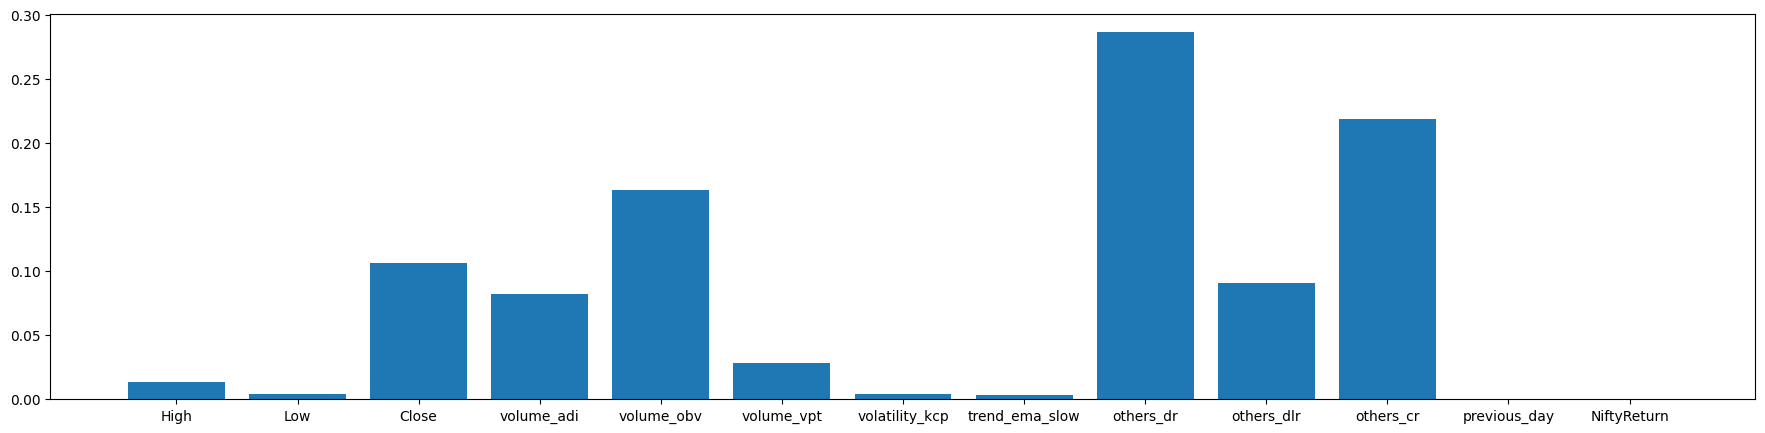

In [83]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [84]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

/var/folders/4_/_fbkdkz531s_92lxx_c_x6n00000gn/T/ipykernel_804/3002898103.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


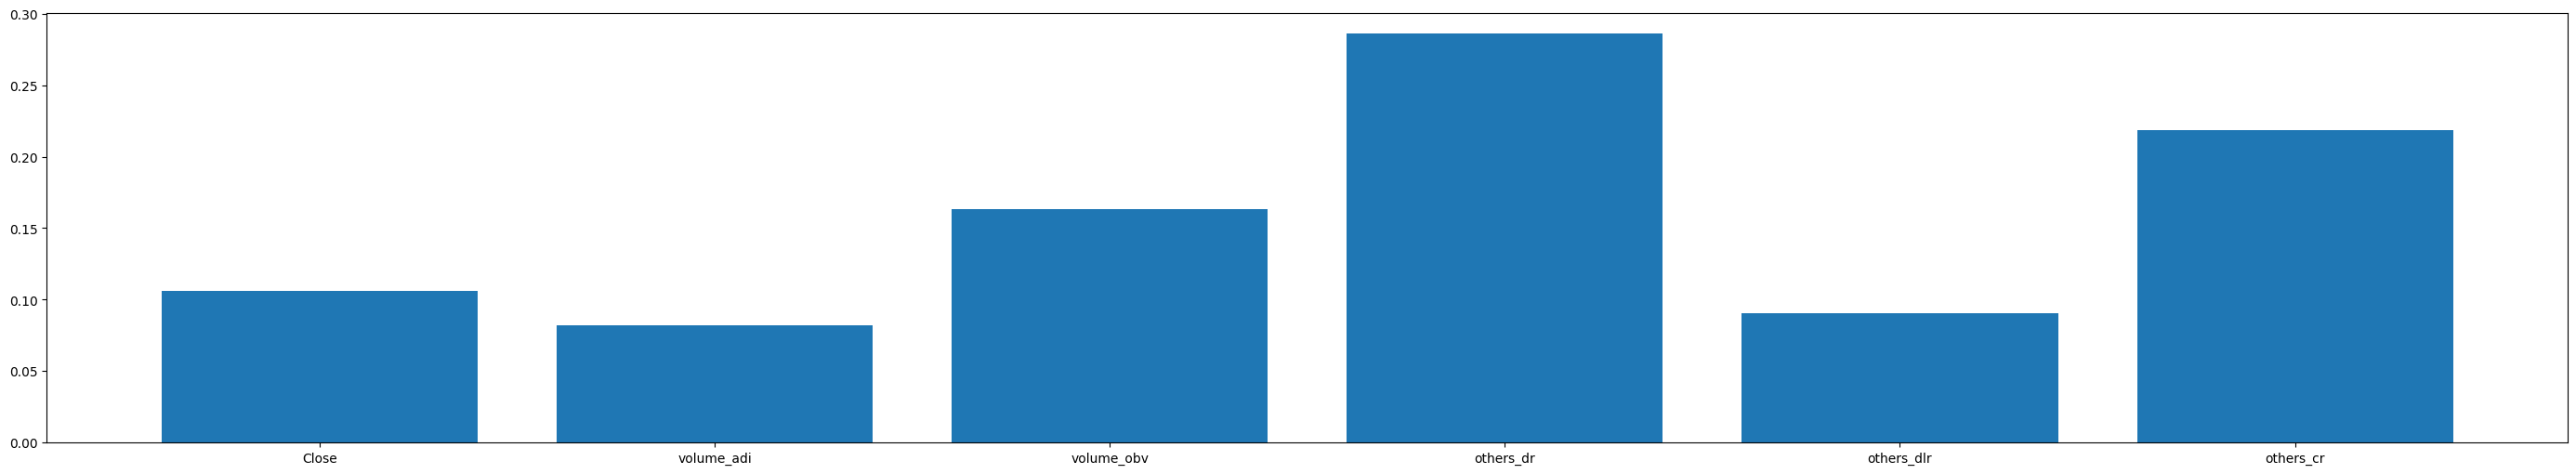

In [85]:
fig, ax = plt.subplots(figsize=(35, 6))

ax.bar(recommended_feature_labels, recommended_feature_score)
fig.show()

In [23]:
recommended_feature_labels

['Close', 'volume_obv', 'others_dr', 'others_dlr', 'others_cr']

In [24]:
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba

array([[0.74655789, 0.25344211],
       [0.81617267, 0.18382733],
       [0.83461494, 0.16538506],
       ...,
       [0.35952933, 0.64047067],
       [0.30016286, 0.69983714],
       [0.63019708, 0.36980292]])

In [25]:
# Test for Overfitting
train_scores, test_scores = list(), list()
y_test_probality =[]
values = [i for i in range(1, 200)]
for i in values:
    classifier = {}
    classifier = RandomForestClassifier(n_estimators=i, max_depth=2, random_state=0)
   
    #with open('./TrainedModel/indicator/{}_model_2.pkl'.format(stock_name), 'rb') as f:
     #   classifier = pickle.load(f)
        
    classifier.fit(X_train, y_train)
    
    # Training Data
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    train_scores.append(accuracy_train)
    
    # Test Data
    y_test_pred = classifier.predict(X_test)
    y_test_probality = classifier.predict_proba(X_test)

    accuracy_test = accuracy_score(y_test, y_test_pred)
    test_scores.append(accuracy_test)

In [33]:
accuracy_test

0.7374631268436578

In [26]:
data_analysis = {
    "real" :        y_test,
    "predication" : y_test_pred,
    "probality_one" :   y_test_probality[:,0],
    "probality_two" :   y_test_probality[:,1]

}
df_d = pd.DataFrame(data_analysis)


In [27]:
failData = df_d[df_d["real"] != df_d["predication"]]
sucessData = df_d[df_d["real"] == df_d["predication"]]
print("fail records :",len(failData),"success reacords :",len(sucessData))

fail records : 712 success reacords : 2000


In [28]:
biggest_num = []
for i in range(0,len(failData)):
        if failData.iloc[i].probality_one > failData.iloc[i].probality_two:
            biggest_num.append(failData.iloc[i].probality_one)
        else:
             biggest_num.append(failData.iloc[i].probality_two)

            


In [30]:
probalityFilterd = failData[failData["biggest_num"] > 0.58]
print("Total Erro len :",len(failData),"Filter error :",len(probalityFilterd))
probalityFilterd.head(50)
#failData

Total Erro len : 712 Filter error : 553


,real,predication,probality_one,probality_two,biggest_num
Date,,,,,
2009-01-19,1,-1,0.735213,0.264787,0.735213
2016-04-08,1,-1,0.613792,0.386208,0.613792
2013-04-12,1,-1,0.660309,0.339691,0.660309
2021-05-06,1,-1,0.611936,0.388064,0.611936
2014-10-17,1,-1,0.792367,0.207633,0.792367
2018-12-26,-1,1,0.391075,0.608925,0.608925
2021-07-23,-1,1,0.327116,0.672884,0.672884
2019-10-25,1,-1,0.622938,0.377062,0.622938
2017-01-11,1,-1,0.678176,0.321824,0.678176


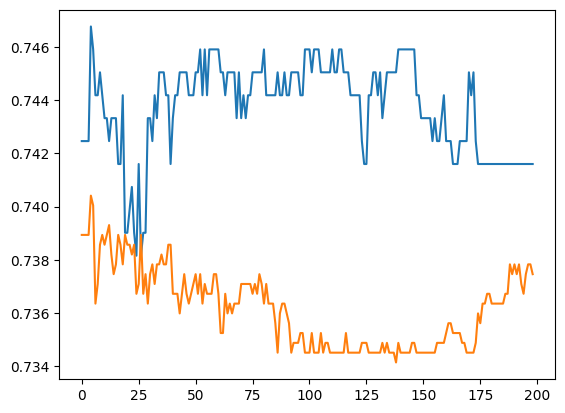

In [31]:
# Plot Results
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()

### Conclusion

We have seen that by introducing PCA, we can dramatically reduce the amount of data required to train our supervised machine learning model (in this case Random Forest). One could further explore information provided by PCA by running K-Means clusters on the PCA data to find certain regimes in the data.

This is the fun part about machine learning, there are many ways to combine methods in the aim to optimize your strategy.

### Useful Resources and Reading

Use Case in Correlation for Stock Analysis: https://python.plainenglish.io/applying-pca-to-stocks-fbad2e51573f

Understanding the VIX: https://www.investopedia.com/stock-analysis/2012/4-ways-to-trade-the-vix-vxx-vxz-tvix-xxv0504.aspx

Using PCA in Forex Trading: 
https://deanstreetlab.github.io/papers/papers/FX%20Trading/Using%20a%20Principal%20Component%20Analysis%20for%20Multi-Currencies-Trading%20in%20the%20Foreign%20Exchange%20Market.pdf